In [1]:
from pathlib import Path
import urllib.request
import zipfile
import io
from pathlib import Path
import os
##Available at: https://github.com/Julian-Beatty/Pyderivatives/
print("Pyderivatives 3.0 Demo Release: Notebook Available at Github: https://github.com/Julian-Beatty/Pyderivatives/")
print("We do an deep analysis on the Brazilian stock market using EWZ options.")
print("This analysis was made very easy using simple Pyderivatives 3.0")


Pyderivatives 3.0 Demo Release: Notebook Available at Github: https://github.com/Julian-Beatty/Pyderivatives/
We do an deep analysis on the Brazilian stock market using EWZ options.
This analysis was made very easy using simple Pyderivatives 3.0


In [2]:
DATA_ZIP_URL = "https://github.com/Julian-Beatty/Pyderivatives/archive/refs/heads/main.zip"

DATA_DIR = Path("Pyderivatives")
DATA_DIR.mkdir(exist_ok=True)

zip_bytes = urllib.request.urlopen(DATA_ZIP_URL).read()
with zipfile.ZipFile(io.BytesIO(zip_bytes)) as z:
    z.extractall()

#print("Downloaded repo contents")
REPO_ROOT = Path("Pyderivatives-main")

In [3]:
REPO_ROOT = Path.cwd().resolve()

# If already inside Pyderivatives-main, stay there
if REPO_ROOT.name != "Pyderivatives-main":
    candidate = REPO_ROOT / "Pyderivatives-main"
    if candidate.exists():
        os.chdir(candidate)
    else:
        raise FileNotFoundError("Pyderivatives-main not found")

#print("Working Directory Set")

In [4]:
import sys
from pathlib import Path

REPO_ROOT = Path.cwd().resolve()          # assumes you already os.chdir(REPO_ROOT) in your bootstrap
REQ_DIR   = REPO_ROOT / "Required_functions"

# Make repo root importable (for option_surface_estimator.py, etc.)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Make Required_functions importable (for helper modules in that folder)
if REQ_DIR.exists() and str(REQ_DIR) not in sys.path:
    sys.path.insert(0, str(REQ_DIR))

#print("Importing Modules")
#print("option_surface_estimator exists:", (REPO_ROOT / "option_surface_estimator.py").exists())
#print("Required_functions exists:", REQ_DIR.exists())

from pricing_kernel_schreindorfer_2025 import *
from Option_market_helper import *
from option_surface_estimator import *


In [5]:
from pathlib import Path
import pickle

DATA_DIR = Path("data")
name = DATA_DIR / "brazil_etf_demo_mini.pkl"

with open(name, "rb") as file:
    brazil_etf_EWZ_demo = pickle.load(file)

option_df = brazil_etf_EWZ_demo["option_df"]
stock_df  = brazil_etf_EWZ_demo["stock_df"]
vix_df    = brazil_etf_EWZ_demo["vix_df"]
#print("Items extracted")

In [6]:
information_dict={} 
unique_dates = option_df["date"].unique() #This may take a while, feel free to reduce the dates even further.

cols = ["date", "exdate", "rounded_maturity", "stock_price",
        "risk_free_rate", "strike", "mid_price"] ##Keep only absolutely neccerssary columns.

##I store each option surface in its own dictionary, indexed by date. 
call_surface_slice_dict = {
    d: g[cols].sort_values(["rounded_maturity", "strike"]).reset_index(drop=True)
    for d, g in option_df.groupby("date", sort=False)
}


We fit a Stochastic Volatility Model with Double Exponential Jumps, and plot.
using_default_bounds=True


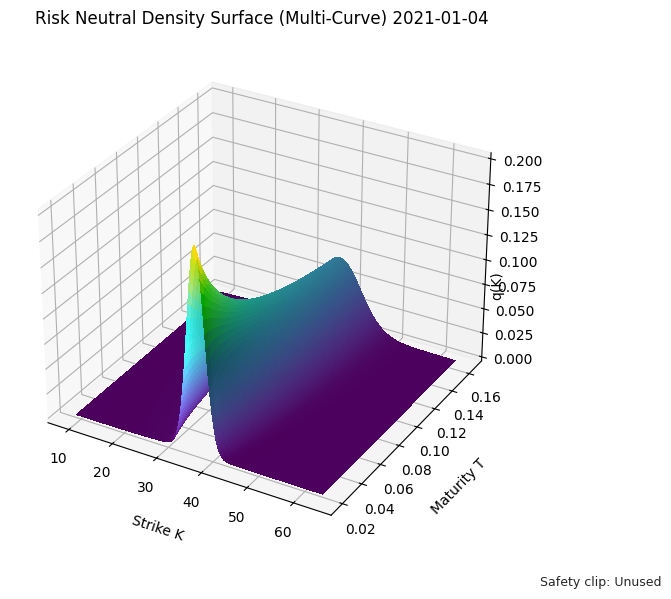

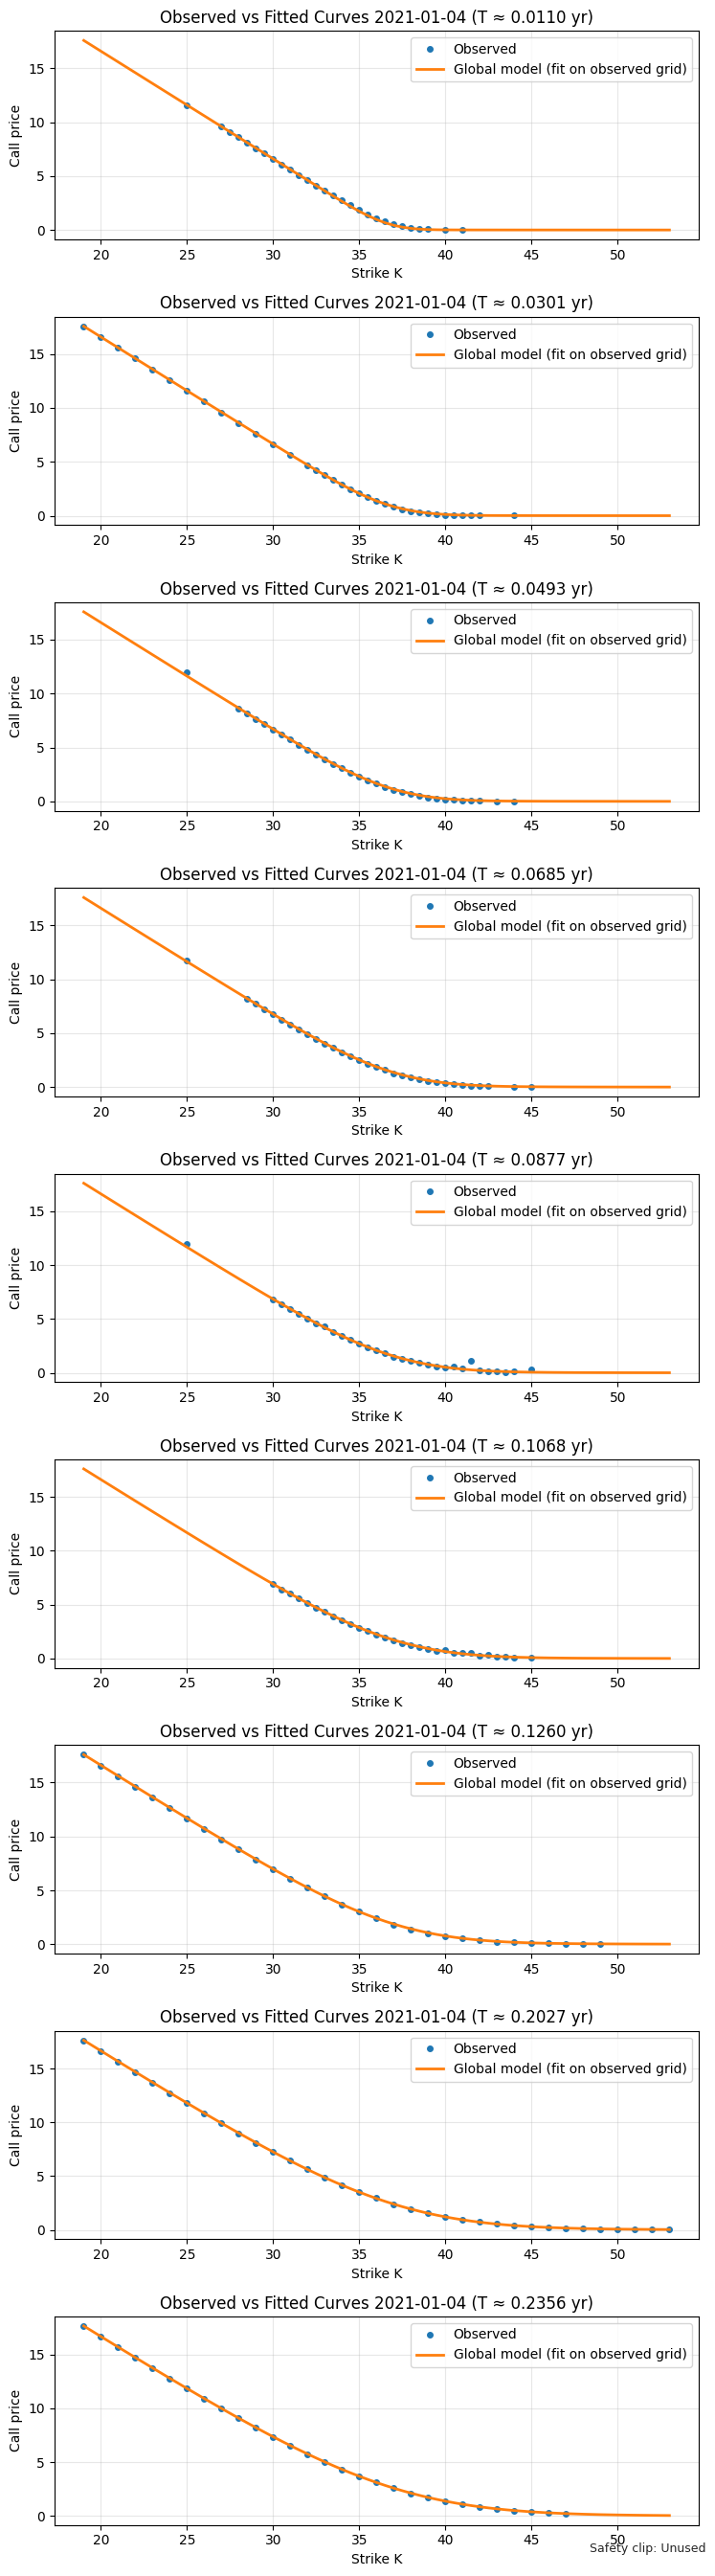

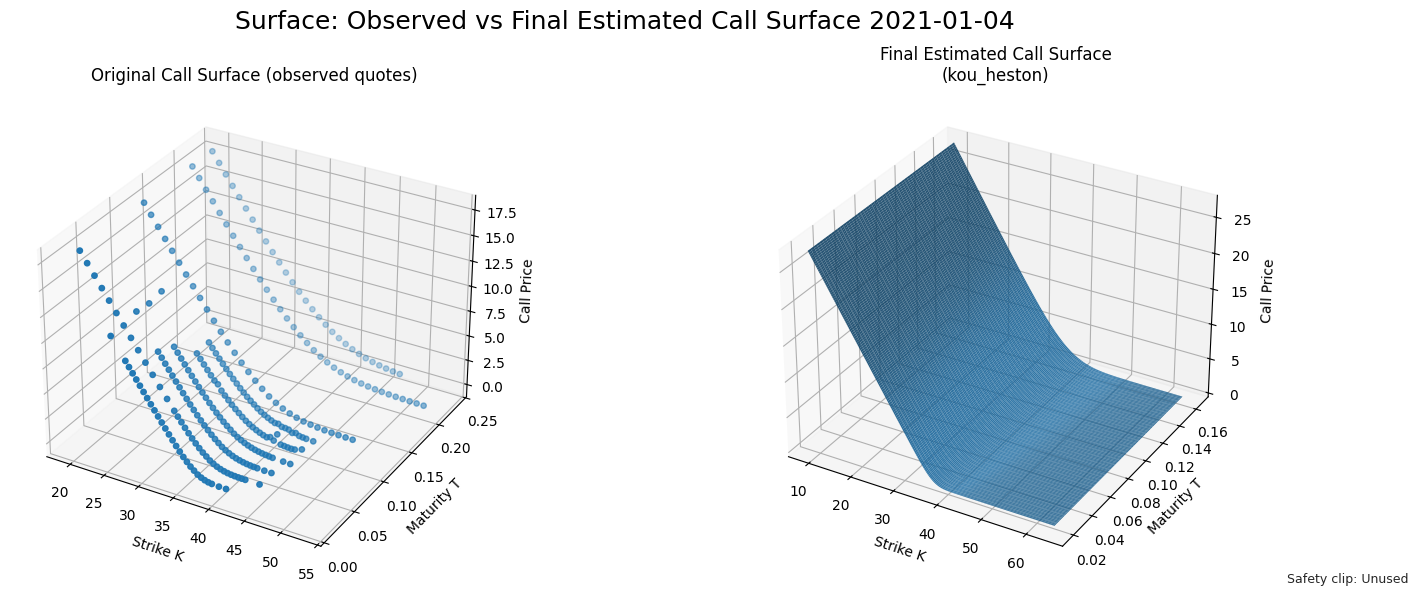

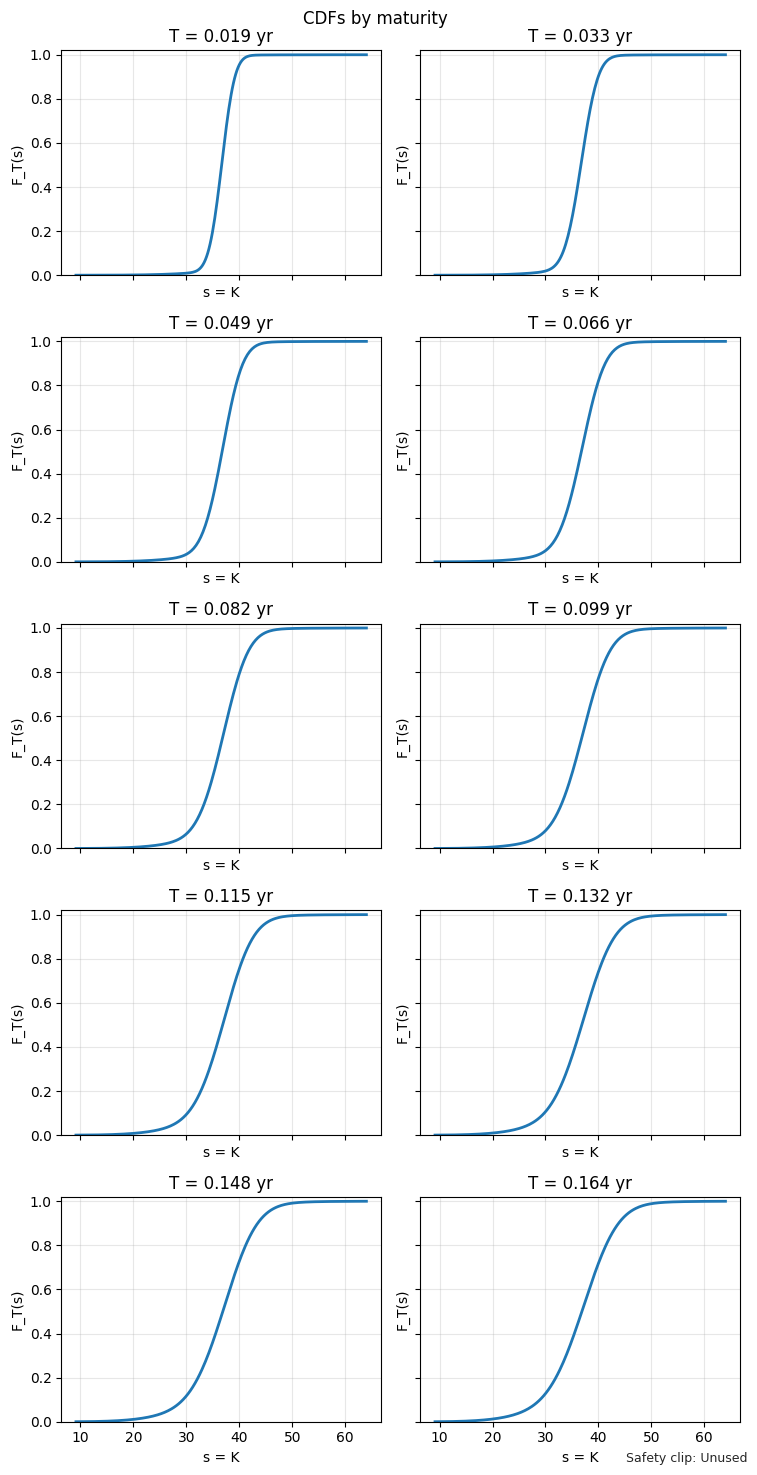

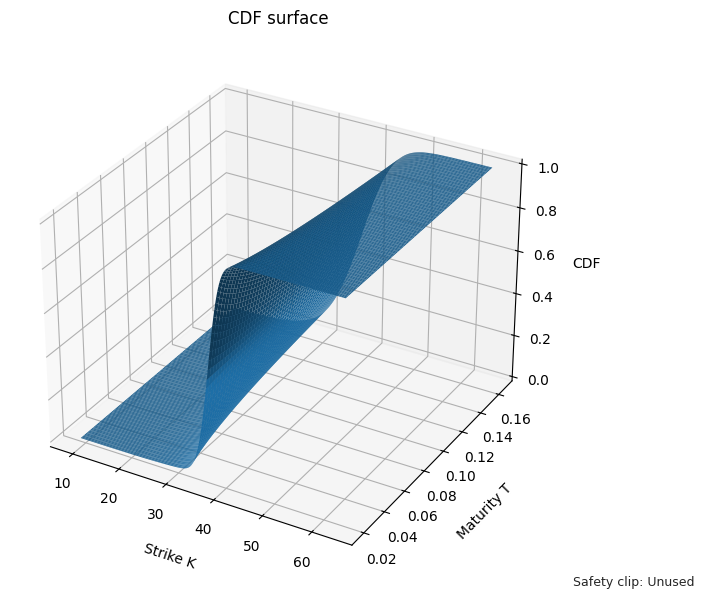

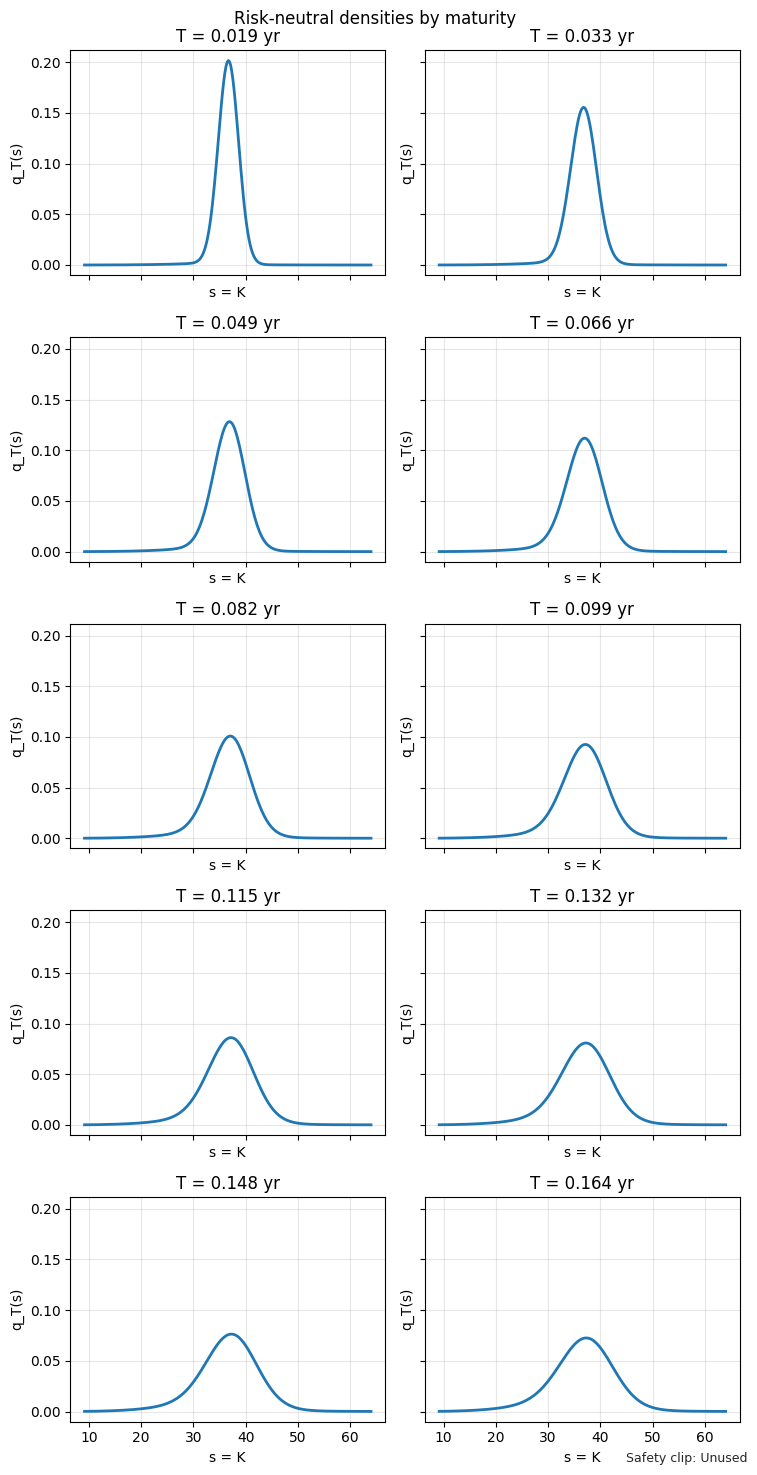

using_default_bounds=True


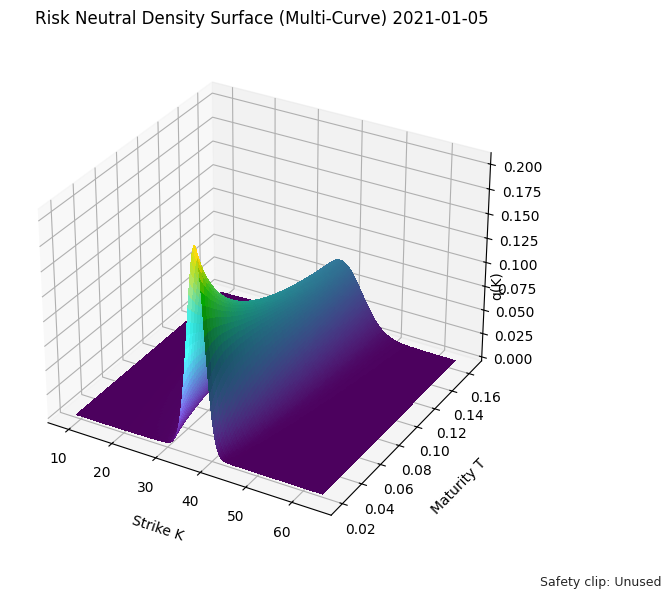

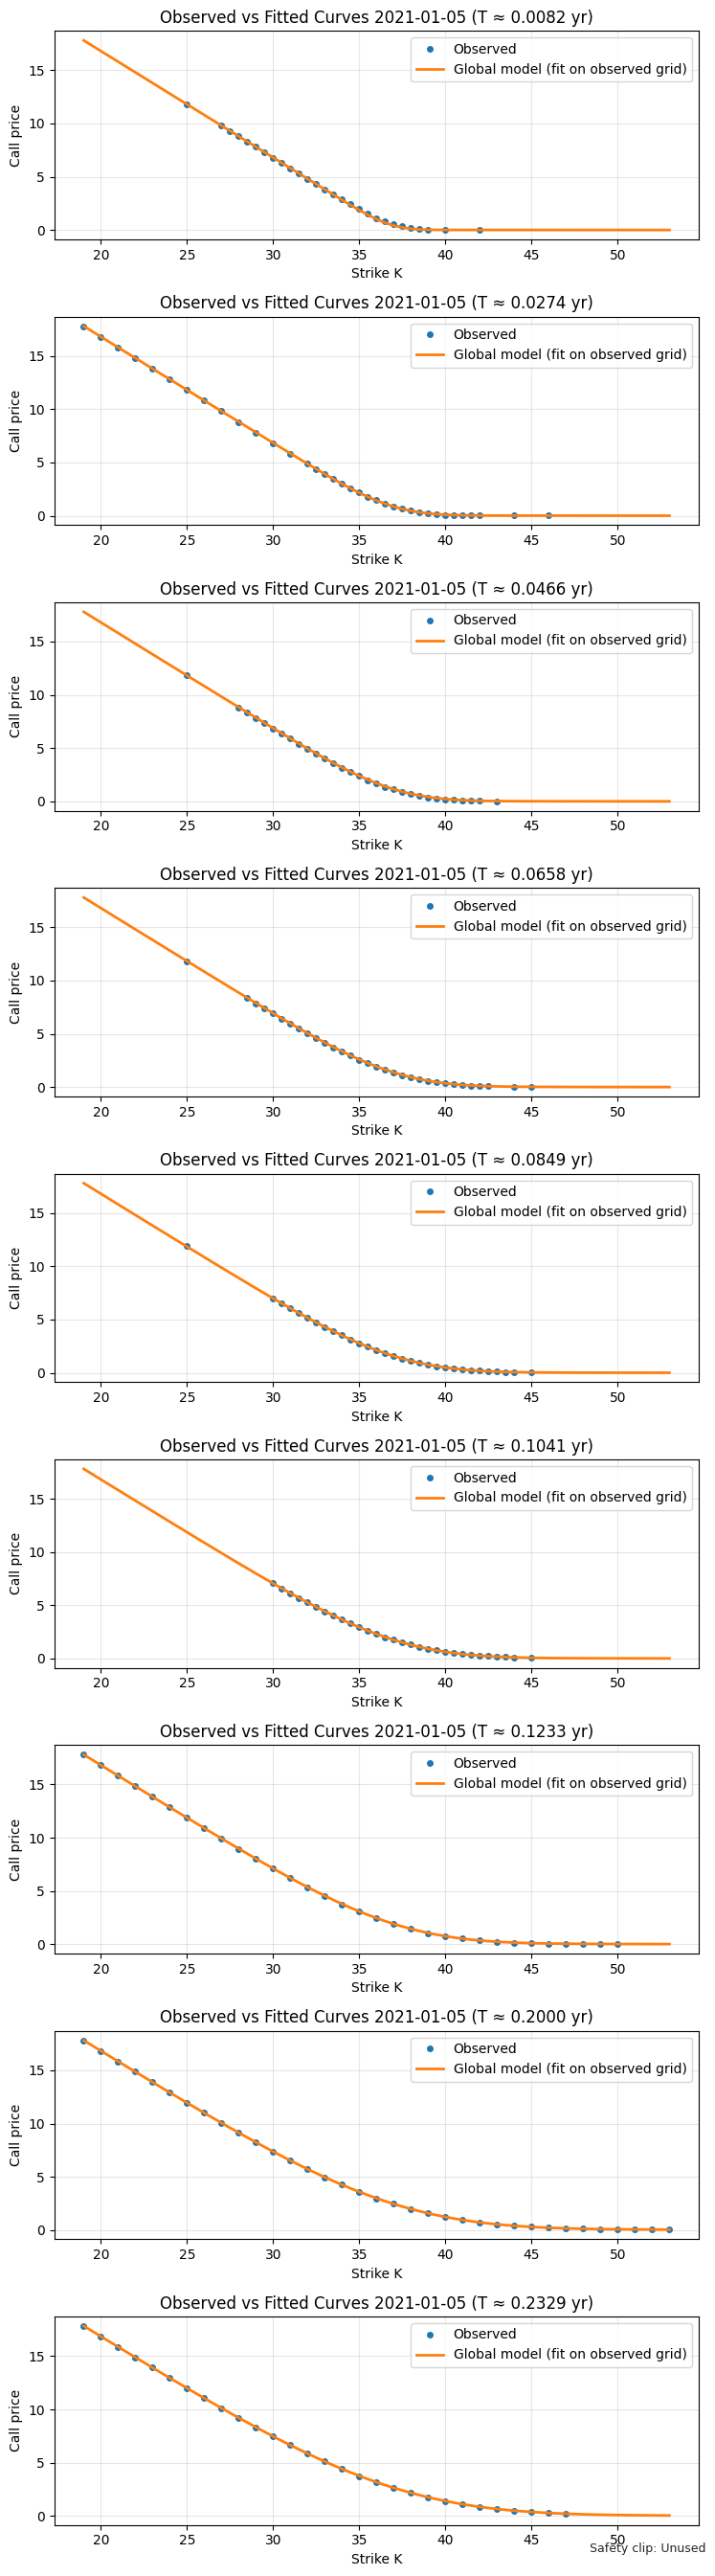

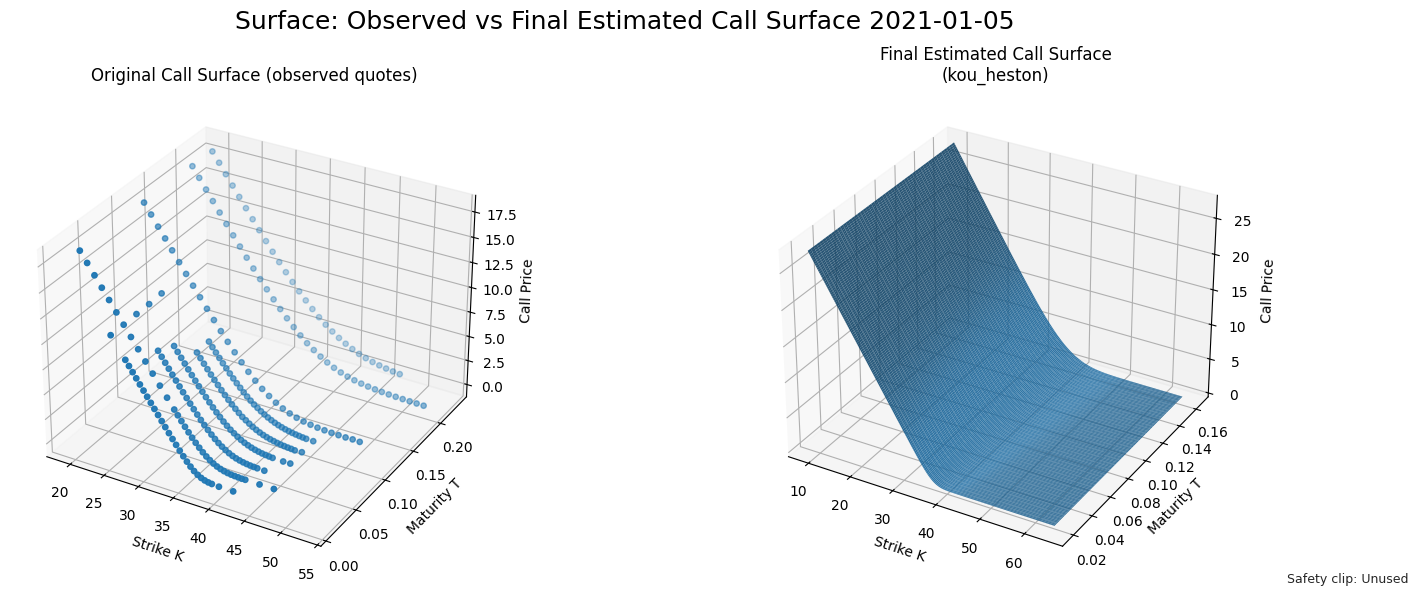

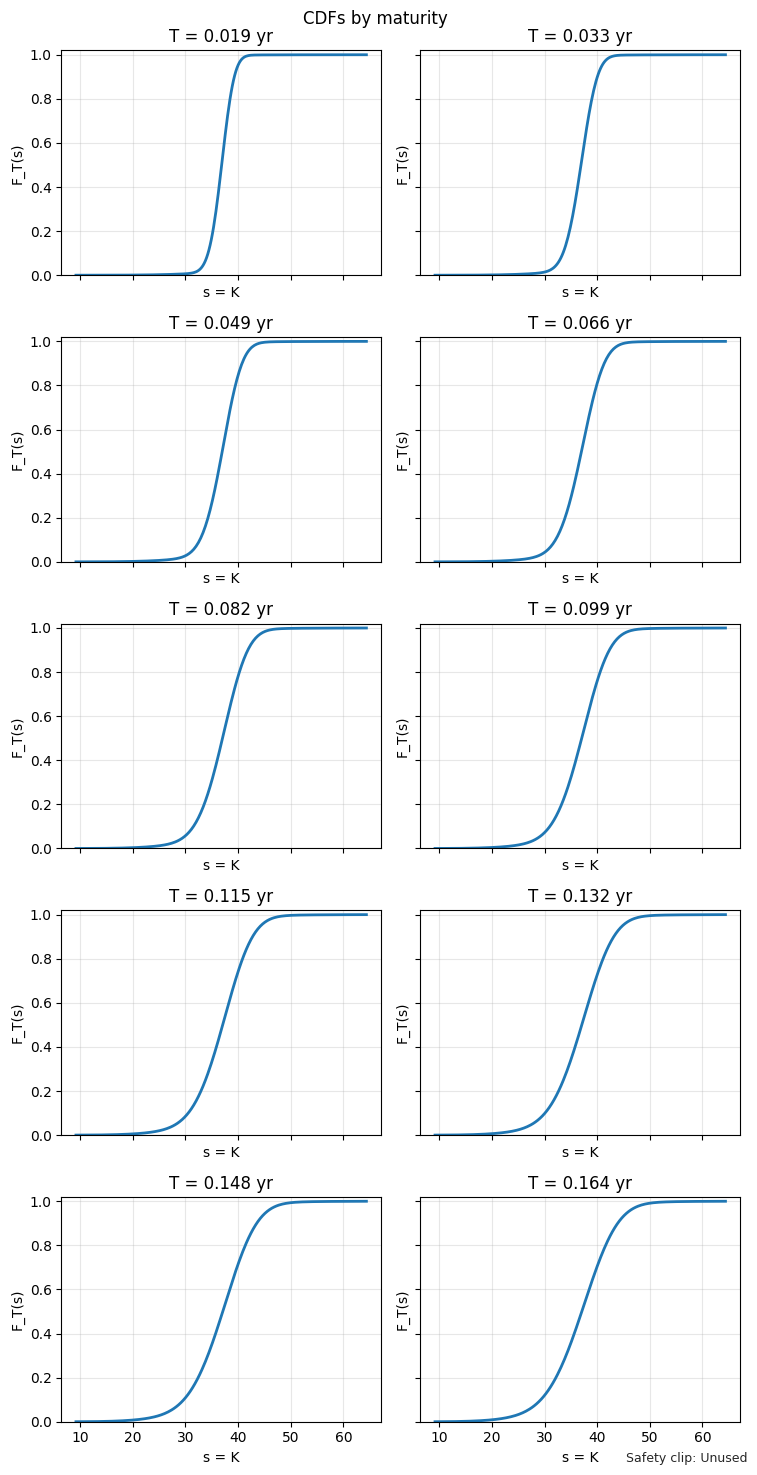

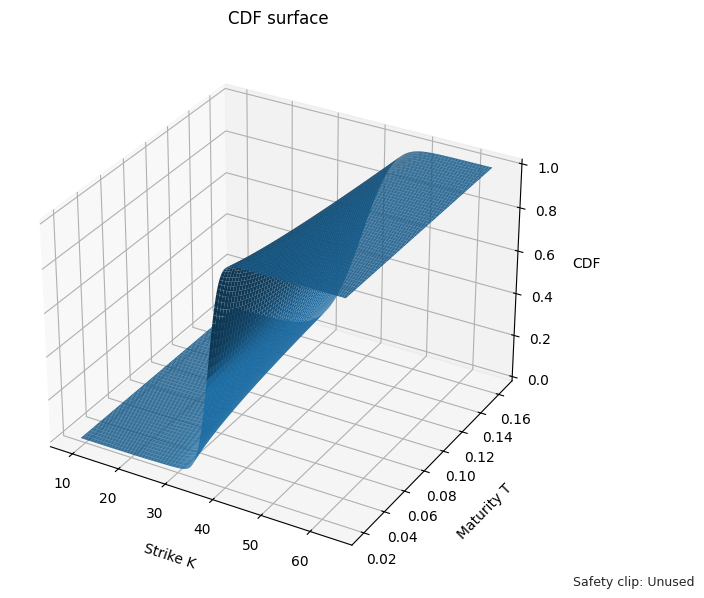

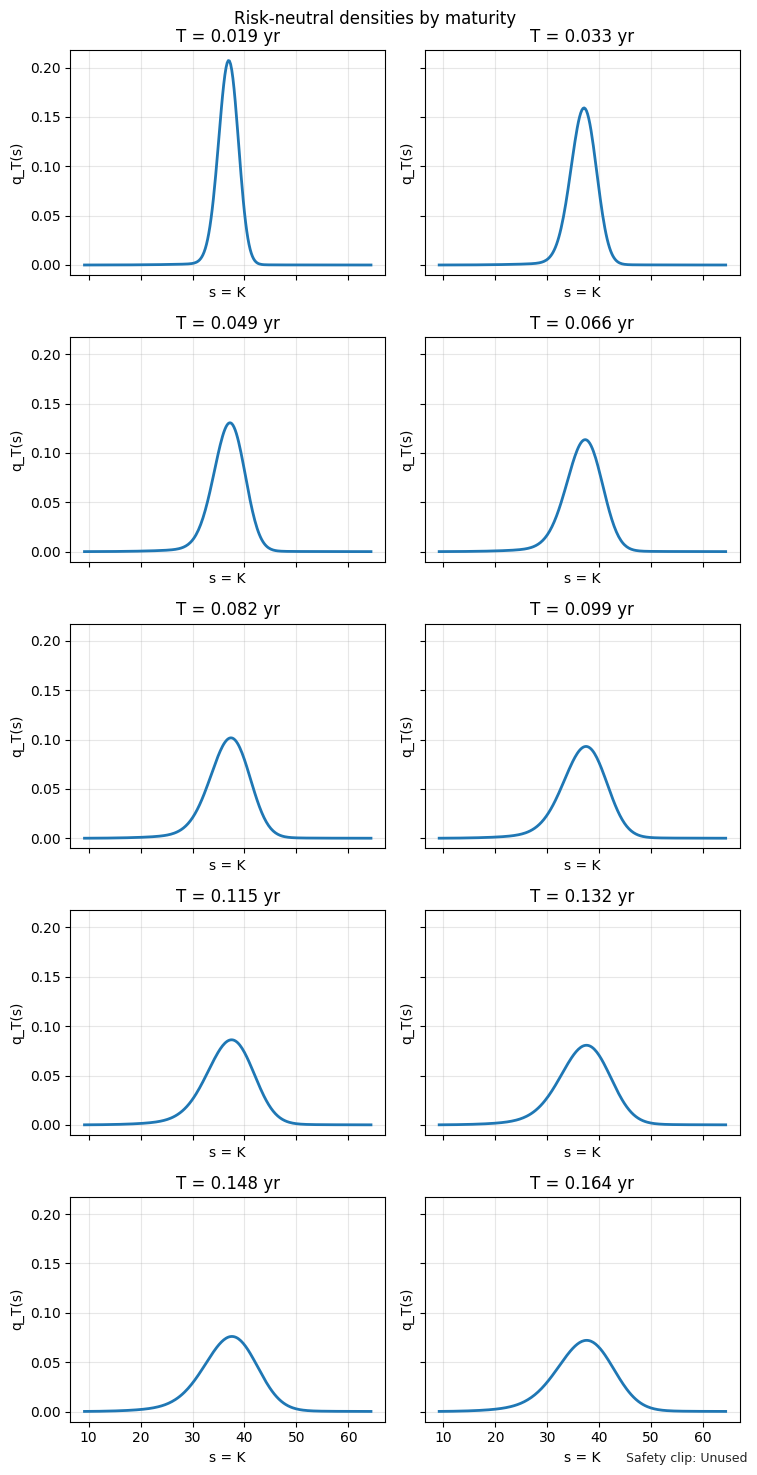

In [7]:
information_dict={} 
print("We fit a Stochastic Volatility Model with Double Exponential Jumps, and plot.")
for i in unique_dates: ##Loop through call_surface dictionary, and fit Kou_heston
    call_surface=call_surface_slice_dict[i]
    strikes, maturities, C_mkt, S0, r = extract_call_surface_from_df(call_surface) ###This extracts strikes/maturities ect. in N, form.
    
    cfg = SurfaceConfig(
        row_model=RowModelConfig(
            model="kou_heston", ##You may use other models
            hkde_quad_N=96,
            hkde_quad_u_max=200.0,
            hkde_verbose=0,


        ),
        fixed_moneyness=np.linspace(0.25, 1.75, 250), ###I evaluate the model on a grid from 0.15 moneyness to 1.75 which should be more than enough
        fixed_maturity=np.arange(7, 61)/365, ##I evaluate the model from a maturity of 7 days to 90 at 1 day interval.
        apply_safety_clip=True, ###Clips densities. If issue set to false
        safety_clip_center="spot",
        safety_clip_jump_factor=0.5*np.e, #these will clip the density to zero towards extreme ends for stability. If the densities still osscilate increase this number to np.e or higher. If the densities are collapsing to zero everywhere, raise this number or turn off
        right_safety_clip_jump_factor=0.5*np.e,
        apply_right_safety_clip=True, 

    )
    est = CallSurfaceEstimator(
            strikes=strikes,
            maturities=maturities,
            S0=S0,
            r=r,
            config=cfg,
        )
    obj = est.fit_surface(C_mkt)
    
    ##############################Now I plot. These will save as folders in your directory. Check to pannels of RND to make sure everything looks clean
    readable_date=i.replace("-", "_")
    
    est.plot_rnd_surface(title=f"Risk Neutral Density Surface (Multi-Curve) {i}",save=f"RND_surface_folder/RND_Surface_{readable_date}.png") #plots RND multi-curve surface
    plot_random_observed_vs_model_curve(est=est,
        strikes_orig=strikes,
        maturities_orig=maturities,
        C_orig=C_mkt,
        plot_all_original=True,
        title_prefix=f"Observed vs Fitted Curves {i}",
        save=f"Call_pannels/Call_pannels_{readable_date}.png"
    )
    ##plot observed vs estimated call surface
    plot_original_vs_final_surface(
        est,
        strikes_orig=strikes,
        maturities_orig=maturities,
        C_orig=C_mkt,
        title=f"Surface: Observed vs Final Estimated Call Surface {i}",
        save=f"Call_surfaces/Call_surface_{readable_date}.png"

    )
    
    est.plot_some_cdfs(n_curves=10, layout="panels", save=f"cdf_pannels/CDF_pannels{readable_date}.png") #plots select CDFS check integration to 1
    est.plot_cdf_surface(save=f"CDF_Surface/CDF_surface{readable_date}.png") #plots CDF check full integration to 1
    est.plot_some_rnds(layout="panels",n_curves=10,save=f"RND_pannels/RND_pannels{readable_date}.png") #plots RND pannels check to make sure no weird behavior

    information_dict[i]=obj ##contains all calculated information indexed by day


In [8]:
CWD = Path.cwd()
DATA_DIR = CWD / "data"

if not DATA_DIR.exists():
    raise FileNotFoundError(f"'data/' folder not found in {CWD}")

# --------------------------------------------------
# Files to load (ordered)
# --------------------------------------------------
parts = [
    "brazil_information_dict_demo_part_1.pkl",
    "brazil_information_dict_demo_part_2.pkl",
    "brazil_information_dict_demo_part_3.pkl",
    "brazil_information_dict_demo_part_4.pkl",
    "brazil_information_dict_demo_part_5.pkl",
]

# --------------------------------------------------
# Load + merge
# --------------------------------------------------
information_dict = {}

for fname in parts:
    path = DATA_DIR / fname
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")

    with open(path, "rb") as f:
        obj = pickle.load(f)

    if not isinstance(obj, dict):
        raise TypeError(f"{fname} is not a dict (got {type(obj)})")

    # merge dictionaries
    overlap = set(information_dict).intersection(obj)
    if overlap:
        raise ValueError(f"Key collision when merging {fname}: {overlap}")

    information_dict.update(obj)

#print(f"✔ Loaded and merged {len(parts)} pickle files")
#print(f"✔ Total keys in merged object: {len(information_dict)}")

In [9]:
#information_dict = load_and_combine_pickles_cwd(
#filename_prefix="brazil_information_dict_demo_part_")


########################Pricing Kernels
####Implements Pricing Kernel according to: Conditional risk and the pricing kernel (2025) Journal of Financial Econometrics
#Jointly estimates the pricing kernel and the physical density, by assuming M(R) follows a flexible parametric form.
# vix_df=pd.read_csv("VIXCLS.csv")
est = PricingKernelSurfaceEstimator(information_dict, stock_df)
pricing_kernel_information={} ##Will store information here

#######################Estimation of the parameter vector Theta(T), I estimate the parameter vector for each day between your largest Maturity option and smallest maturity option
##Interpolated on one day. For each Maturity T
##1) Search each dictionary for the Risk neutral density of maturity T Q(T). If that exact maturity isn't found, it will fallback and use for next closest density, up to a tolerance level.
##If no suitable density within that tolerance exists, it skips that dictionary and moves to the next day.
##(2) After collecting densities, it runs basic numerical checks to densities, and throws out them out. If the Density qouted at day t, of Maturity T does not having a matching realized return
## Rt+T that can be calculated in stock_df, it is thrown out.
##(2.1) If not enough observations are available for LL it just uses initial parameters. Bad estimation, may change this later to fall back to later Theta(T)
##(3)For the estimate of conditional volatility, I use either the VIX, or the median ATM-IV.
##(4) Estimates the likelihood according to paper 

theta_cache = est.fit_theta_master_grid(
    N=2, #2nd order polynomial as recommended by paper Produces U shaped P-kernels
    Ksig=1, #allows P-kernel to vary with vol
    tol_days=5,
    day_step=1,
    min_obs_per_T=12,
    r_grid_size=800,
    use_vix=False,
    multistart=False,
    n_random_starts=0,
    theta_bound=None,  # no bounds on c
    verbose=False,
)

------------------------------------------------------------------------------------------------.
We using the Pricing Kernel command to back out the Physical Density and Pricing kernel.


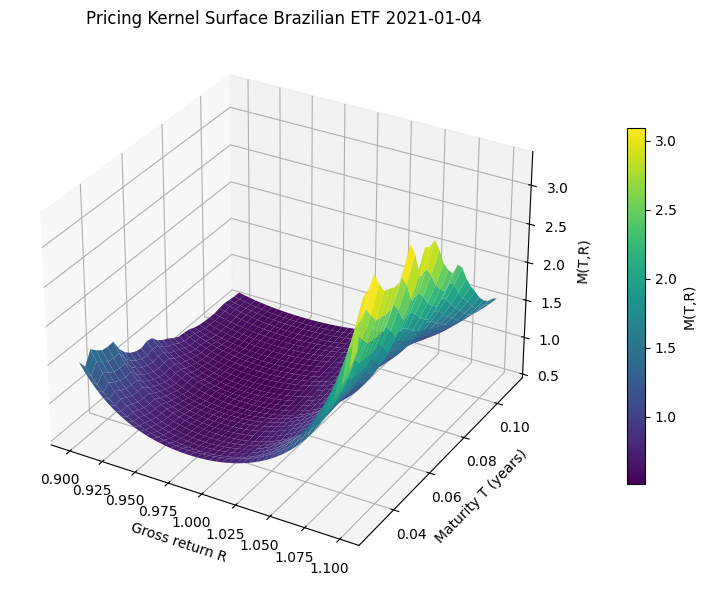

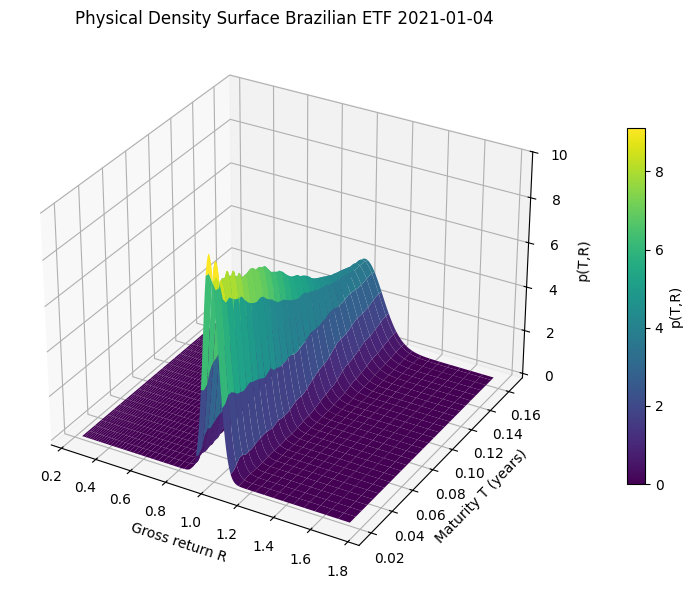

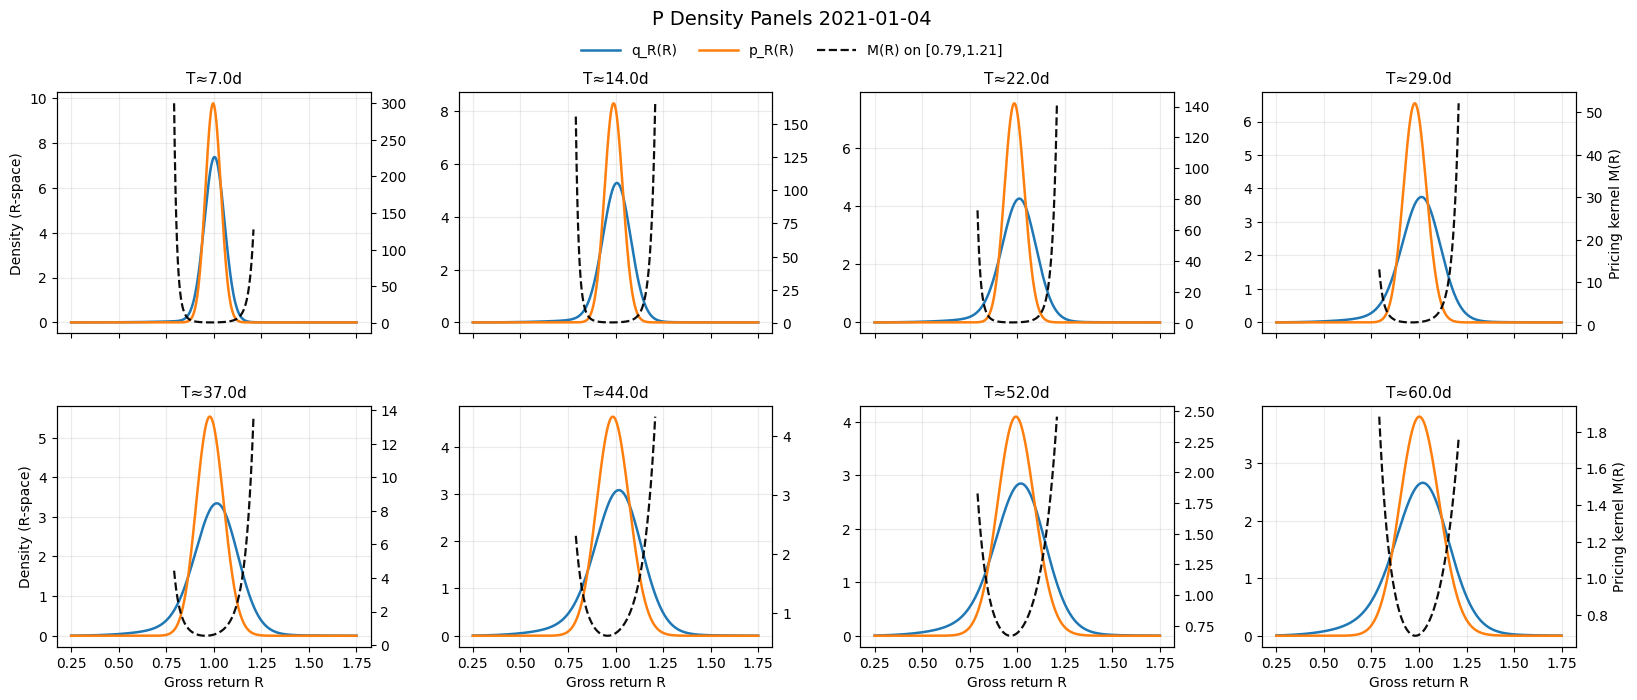

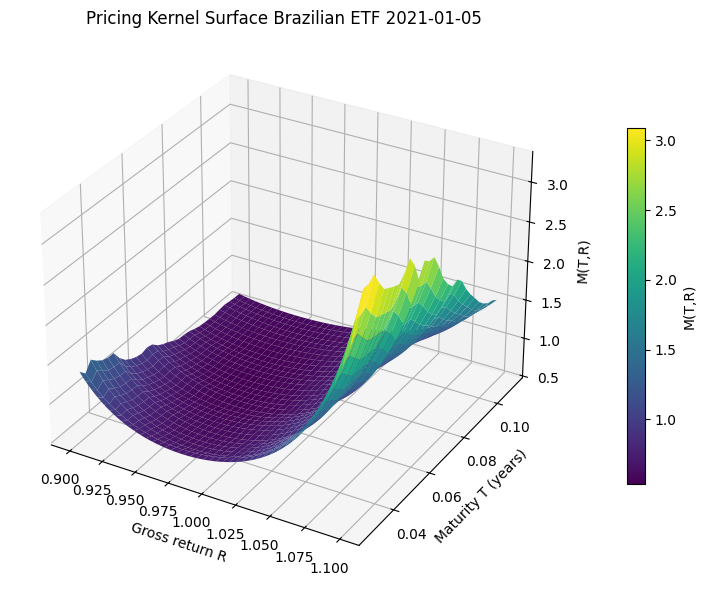

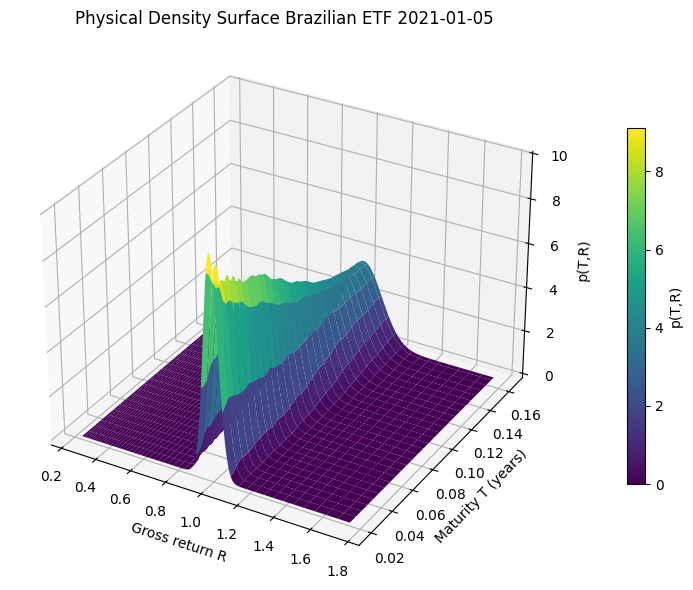

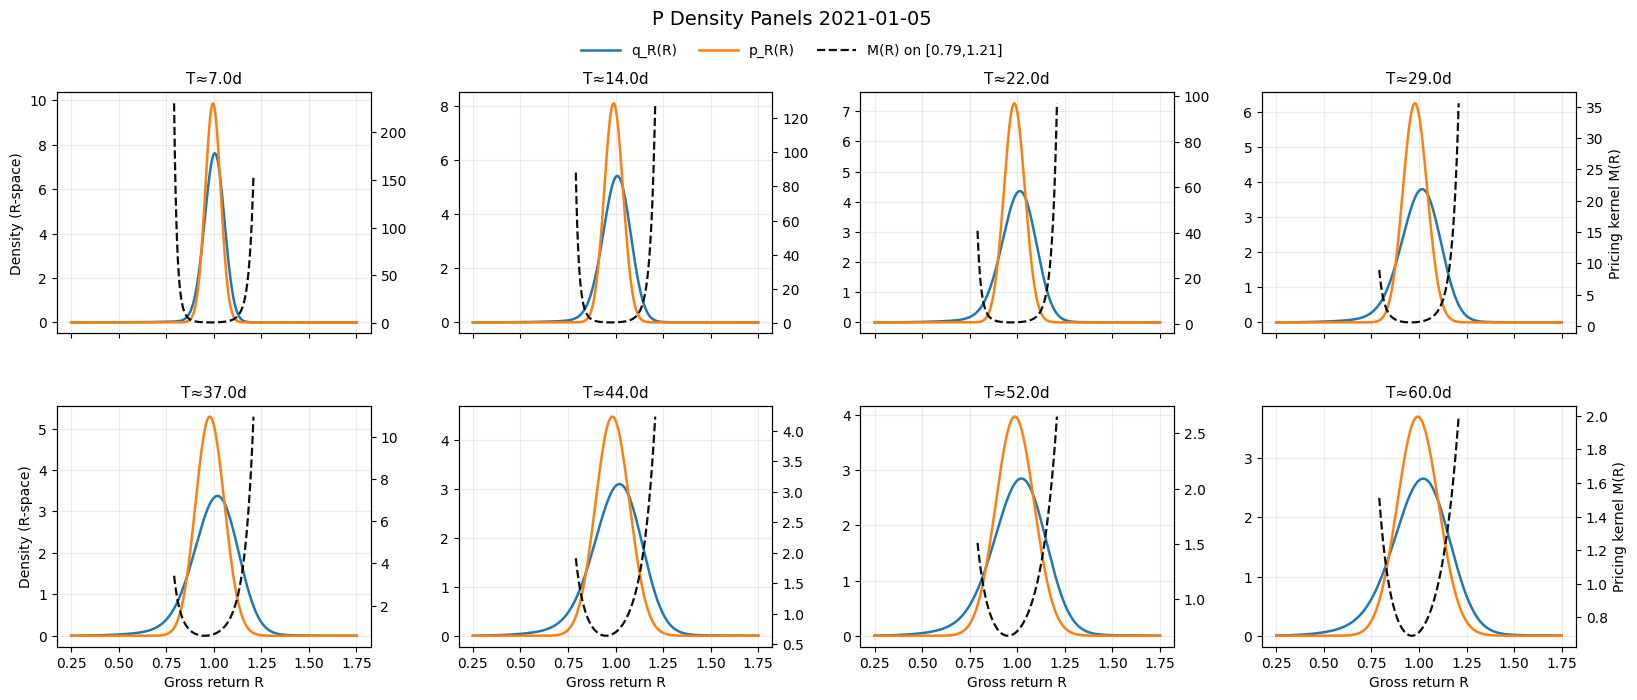

In [10]:
print("------------------------------------------------------------------------------------------------.")
print("We using the Pricing Kernel command to back out the Physical Density and Pricing kernel.")
for date in unique_dates: #Loops through dates and calculates P(T) ect..
    date_str = pd.to_datetime(date).strftime("%Y-%m-%d")  # key format

    test_date=date
    out = est.evaluate_surfaces_for_date_master(date_str, theta_cache, tol_days_eval=4, warn=True)

    est.plot_pricing_kernel_surface(title=f"Pricing Kernel Surface Brazilian ETF {date_str}",R_bounds=(0.9,1.1),T_bounds=(10/365,40/365))
    est.plot_physical_density_surface(title=f"Physical Density Surface Brazilian ETF {date_str}",save=f"Physical_surfaces/p_{date_str}.png")
    est.plot_panel(title=f"P Density Panels {date_str}", save=f"physical_Panels/physical_panel_{date_str}.png", panel_shape=(2,4),truncate=True, trunc_mode="rbounds", r_bounds=(0.79, 1.21)) #can adjust alpha to see more plot
    
    pricing_kernel_information[date_str]=out
 

We also plot the relative risk aversion surface, and plot the average across maturity.


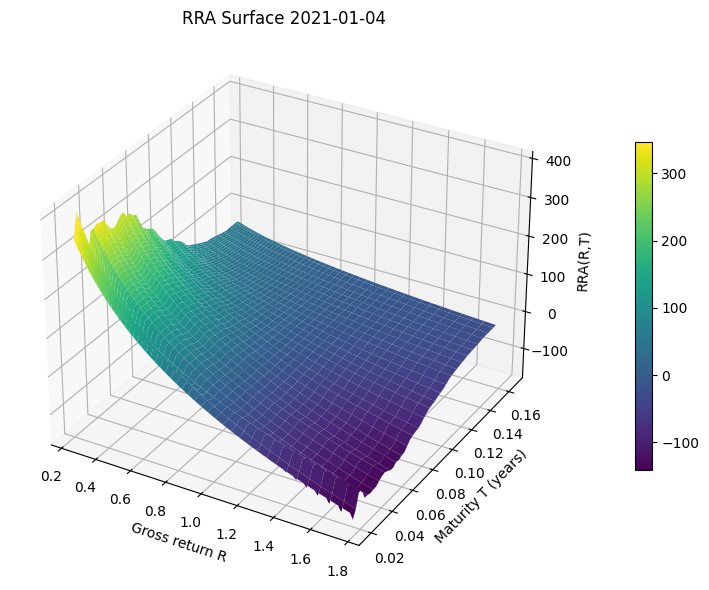

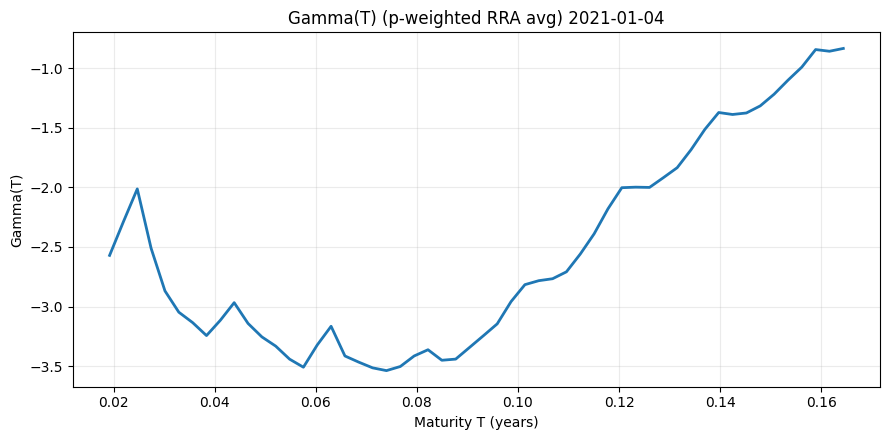

In [11]:
print("We also plot the relative risk aversion surface, and plot the average across maturity.")
out_one = compute_rra_for_all_dates(
    pricing_kernel_information,
    date=unique_dates[0],
    out_dir="outputs/rra_one",
)